In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from datetime import datetime # Para pegar a data atual


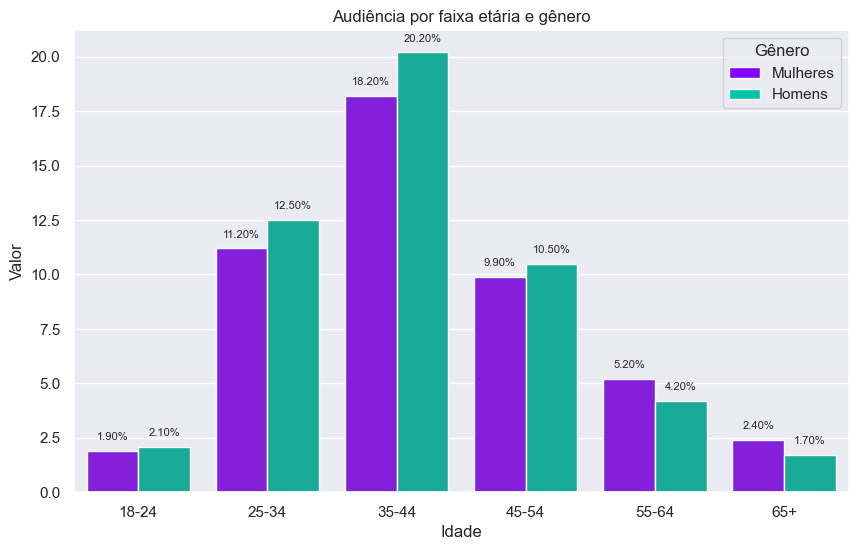

In [20]:
# Lê o arquivo CSV
idade = pd.read_csv("tabelas/idadeOut23.txt")

# Calcula os totais das colunas de homens e mulheres,
idade['t_h'] = ((0 * idade['h_fb']) + (28147 * idade['h_ig'])) / 28147
idade['t_m'] = ((0 * idade['m_fb']) + (28147 * idade['m_ig'])) / 28147

# Reorganização da estrutura dos dados usando a função melt

"""
melt está sendo usada para transformar o DatraFrame 'idade' de um formato largo para um formato longo.
Em termos mais simples, a ideia é converter os dados de um formato em que cada coluna representa uma variável para um formato em que essas variáveis estão representadas em linhas.

idade é o dataframe original com as colunas 'Idade', 't_h' e 't_h'.

id_vars=['Idade'] especifica que a coluna idade será mantida como uma coluna identificadora.

value_vars=['t_m', 't_h'] especifica as colunas que serão "derretidas" e transformadas em uma única coluna chamada 'value'.

O resultado é o DataFrame melted_data, que terá três colunas: 'Idade', 'variable' (contendo 't_m' ou 't_h'), e 'value' (contendo os valores correspondentes a 't_m' ou 't_h').
"""
melted_data = pd.melt(idade, id_vars=['Idade'], value_vars=['t_m', 't_h'])

# Cria o gráfico usando seaborn e matplotlib

"""
x="Idade": Especifica que os valores da coluna 'Idade' do DataFrame melted_data serão usados como coordenadas no eixo x do gráfico de barras.

y="value": Especifica que os valores da coluna 'value' do DataFrame melted_data serão usados como coordenadas no eixo y do gráfico de barras.

hue="variable": Essa opção cria barras coloridas com base nos valores únicos na coluna 'variable' do DataFrame melted_data. Cada valor único na coluna 'variable' corresponderá a uma cor diferente.

data=melted_data: Especifica o DataFrame que contém os dados a serem plotados.
"""

sns.set(style="darkgrid") # Define o estilo do seaborn
plt.figure(figsize=(10,6)) # Cria nova figura com o tamanho especificado
sns.barplot(x='Idade', y='value', hue='variable', data=melted_data, palette=["#8700f9", "#00c4aa"]) # Cria o gráfico de barras. Recebe o que vai ficar em cada eixo.

# Add rótulos e títulos ao gráfico
plt.xlabel('Idade')
plt.ylabel('Valor')
plt.title('Audiência por faixa etária e gênero')

# Adiciona rótulos nos topos das barras

"""for p in plt.gca().patches: Itera sobre as "patches" (elementos retangulares) presentes no eixo atual (gca() significa "get current axis") do gráfico.

if p.get_height() > 0: Verifica se a altura da barra (get_height()) é maior que zero. Isso é feito para evitar a adição de rótulos em barras com altura zero.

plt.gca().annotate(): Adiciona um rótulo no topo da barra formatado como uma porcentagem com duas casas decimais (f'{p.get_height():.2f}%').

(p.get_x() + p.get_width() / 2., p.get_height()) especifica a posição do rótulo no gráfico, sendo o centro do topo da barra.

ha='center' e va='center' definem a alinhamento horizontal e vertical do rótulo como central.

xytext=(0, 10) move o rótulo 10 pontos para cima a partir da posição central.

textcoords='offset points' indica que as coordenadas especificadas em xytext estão em pontos.

fontsize=8 define o tamanho da fonte do rótulo como 8.
"""

for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.2f}%',  # Adiciona rótulo formatado com a altura da barra
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
        

# Cria elementos de linha personalizados para a legenda
legend_elements = [Patch(facecolor="#8700f9", edgecolor='w', label='Mulheres'),
                    Patch(facecolor="#00c4aa", edgecolor='w', label='Homens')]

# Exibição do gráfico com a legenda personalizada
plt.legend(title="Gênero", handles=legend_elements)
plt.show()

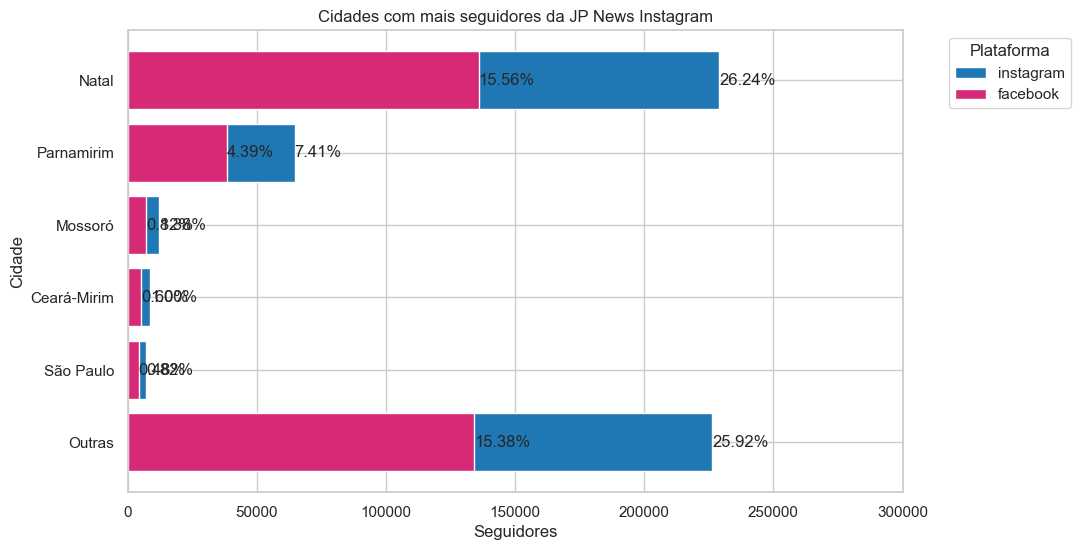

In [144]:
# Dados
# sourcery skip: list-comprehension, move-assign-in-block, remove-unused-enumerate
c = ["Natal", "Parnamirim", "Mossoró", "Ceará-Mirim", "São Paulo", "Outras"]
totalSegFB = 325000
totalSegIG = 548000
cidades = pd.DataFrame({
    'cidade': pd.Categorical(c, categories=c[::-1]),
    'facebook': [totalSegFB * 0.418, totalSegFB * 0.118, totalSegFB * 0.022, totalSegFB * 0.016, totalSegFB * 0.013, totalSegFB * 0.413],
    'instagram': [totalSegIG * 0.418, totalSegIG * 0.118, totalSegIG * 0.022, totalSegIG * 0.016, totalSegIG * 0.013, totalSegIG * 0.413]
})

# Substituir valores None por 0
cidades['facebook'].fillna(0, inplace=True)

# Total de seguidores
total_fb = cidades['facebook'].sum()
total_ig = cidades['instagram'].sum()
t = total_fb + total_ig

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = []
colors = ["#1f78b4", "#d62976"]

# # Adicionar barras
# for i, (platform, color) in enumerate(zip(['facebook', 'instagram'], colors)):
#     bars.append(ax.barh(cidades['cidade'], cidades[platform], color=color, label=platform))

# Adicionar barras
bars.extend(
    ax.barh(cidades['cidade'], cidades[platform], color=color, label=platform)
    for i, (platform, color) in enumerate(
        zip(['instagram', 'facebook'], colors)
    )
)
# Adicionar rótulos percentuais ao lado das barras
for bar, city in zip(bars, cidades['cidade']):
    for rect in bar:
        width = rect.get_width()
        if round(width / t, 4) > 0:
            ax.text(width, rect.get_y() + rect.get_height() / 2, f'{100 * round(width / t, 4):.2f}%', va='center', ha='left')

# Inverter a ordem das barras no eixo y
ax.invert_yaxis()

# Configurações adicionais
ax.set_xlabel('Seguidores')
ax.set_ylabel('Cidade')
ax.set_title('Cidades com mais seguidores da JP News Instagram')
ax.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0,300000)
plt.show()


       cidades  valores
0        Natal     41.8
1   Parnamirim     11.8
2      Mossoró      2.2
3  Ceará-Mirim      1.6
4    São Paulo      1.3


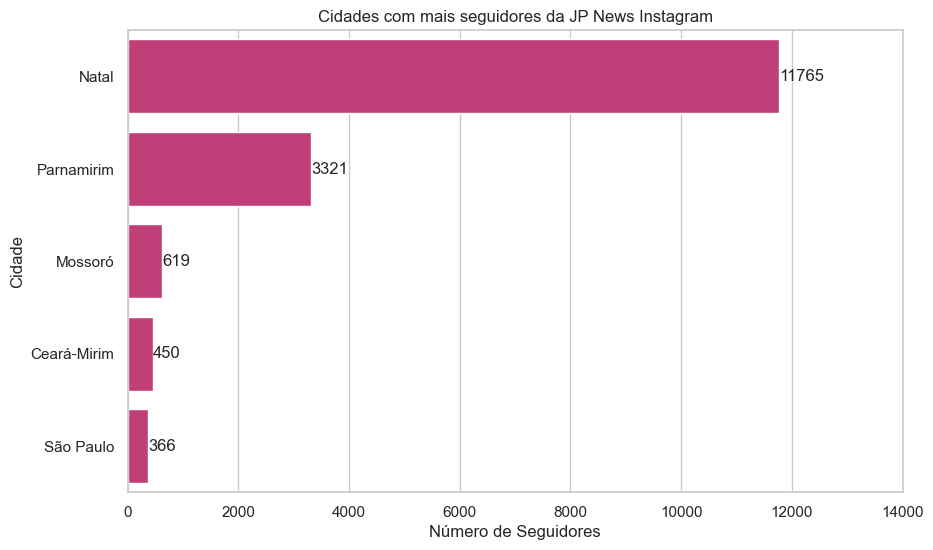

In [93]:
# Carregar dados do CSV
dados = pd.read_csv('tabelas/publico.csv', encoding='UTF-16LE')
print(dados.head())

# Calcular os valores absolutos correspondentes às porcentagens
total_followers = 28147
dados['valores_absolutos'] = round((dados['valores'] / 100) * total_followers)


# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='valores_absolutos', y='cidades', data=dados, color="#d62976")

# Adicionar rótulos percentuais ao lado das barras
for index, value in enumerate(dados['valores_absolutos']):
    plt.text(value, index, f'{value:.0f}', va='center', ha='left')

plt.xlim(0, 14000)

# Configurações adicionais
plt.xlabel('Número de Seguidores')
plt.ylabel('Cidade')
plt.title('Cidades com mais seguidores da JP News Instagram')


plt.show()


In [152]:
import pandas as pd
import plotly.express as px

# Carregar dados do CSV
dados = pd.read_csv('tabelas/publico.csv', encoding='UTF-16LE')

# Calcular os valores absolutos correspondentes às porcentagens
total_followers = 28147
dados['valores_absolutos'] = round((dados['valores'] / 100) * total_followers)

# Criar o gráfico interativo com plotly
fig = px.bar(
    dados,
    x='valores_absolutos',
    y='cidades',
    orientation='h',  # Definir a orientação para horizontal
    text='valores_absolutos',  # Usar a coluna 'valores_absolutos' para rótulos de hover
    title='Cidades com mais seguidores da JP News Instagram',
    labels={'valores_absolutos': 'Número de Seguidores', 'cidades': 'Cidade'},
    height=400,
    width=800
)

# Configurar o layout do hover
fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')

# Exibir o gráfico interativo
fig.write_html('plotly_chart.html')


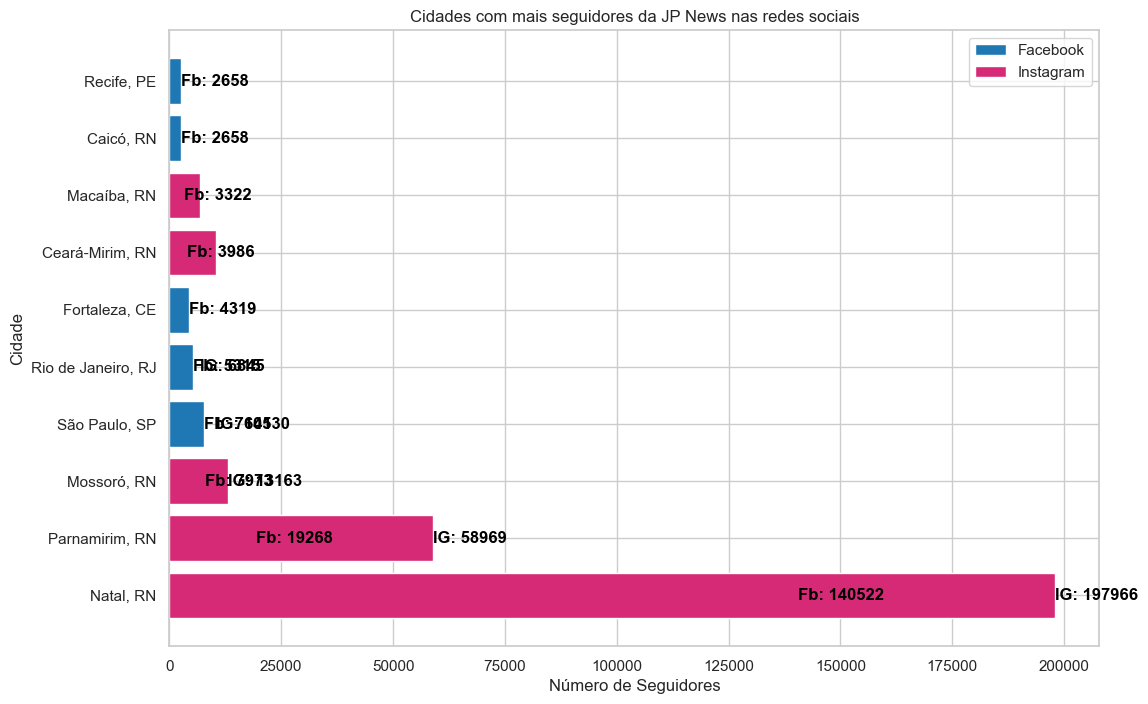

In [147]:
# Carregar dados do CSV
dados = pd.read_csv('tabelas/meta.csv', encoding='UTF-16LE', decimal=',')

dados['valorFB'] = dados['valorFB'].str.replace('%', '').str.replace(',', '.').astype(float)
dados['valorIG'] = dados['valorIG'].str.replace('%', '').str.replace(',', '.').astype(float)

totalSegFB = dados['TotalFB'][0].astype(int)
totalSegIG = dados['TotalIG'][0].astype(int)

# Calcular os valores absolutos correspondentes às porcentagens
total_followers = 140000
dados['Seguidores_Facebook'] = (dados['valorFB'] / 100) * totalSegFB
dados['Seguidores_Instagram'] = (dados['valorIG'] / 100) * totalSegIG

# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar o gráfico
plt.figure(figsize=(12, 8))

# Adicionar barras para Facebook e Instagram
plt.barh(dados['cidadesFB'], dados['Seguidores_Facebook'], color='#1f78b4', label='Facebook')
mask_not_nan = ~dados['Seguidores_Instagram'].isna()
plt.barh(dados['cidadesIG'][mask_not_nan], dados['Seguidores_Instagram'][mask_not_nan], color='#d62976', label='Instagram')


# Adicionar rótulos percentuais ao lado das barras
for index, (value_fb, value_ig) in enumerate(zip(dados['Seguidores_Facebook'], dados['Seguidores_Instagram'])):
    if not np.isnan(value_ig) and np.isfinite(value_ig):
        plt.text(value_ig, index, f'IG: {value_ig:.0f}', va='center', ha='left', color='black', fontweight='bold', zorder=4)
    if not np.isnan(value_fb) and np.isfinite(value_fb):
        plt.text(value_fb, index, f'Fb: {value_fb:.0f}', va='center', ha='left', color='black', fontweight='bold', zorder=4)


# Configurações adicionais
plt.xlabel('Número de Seguidores')
plt.ylabel('Cidade')
plt.title('Cidades com mais seguidores da JP News nas redes sociais')
plt.legend()

plt.show()

ModuleNotFoundError: No module named 'cairosvg'

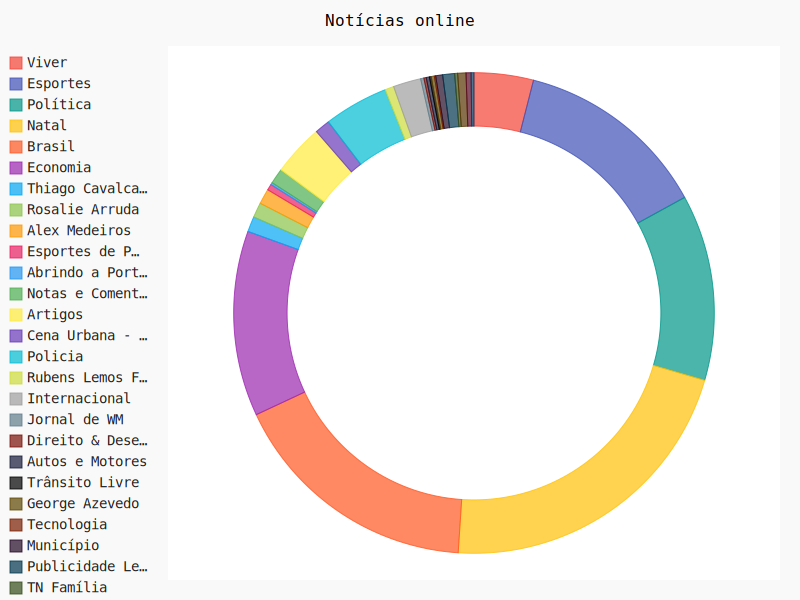

In [36]:
import pygal

dados_Noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

editoriais_unicos = dados_Noticias['edi_descricao'].unique()

pie_chart = pygal.Pie(inner_radius = 0.7)
#pie_chart = pygal.Pie(inner_radius = 0.4, half_pie=True)
pie_chart.title = "Notícias online"
for item in editoriais_unicos:
    pie_chart.add(item, dados_Noticias['edi_descricao'].value_counts()[item])

pie_chart

In [5]:
# Recebe a tabela com as notícias
df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

df_reporter = pd.read_csv('tabelas/noticias online/usuarios.csv')

# print(df_noticias['usu_id_fk'])
# print(df_reporter[['usu_id', 'usu_nome']])

ids_noticias = df_noticias['usu_id_fk']
ids_reporter = df_reporter[['usu_id', 'usu_nome']]

ids_noticias = ids_noticias.rename('usu_id')
#print(ids_noticias)

merge_ids_reporterNoticias = pd.merge(ids_noticias, ids_reporter, on='usu_id', how='left')

print(merge_ids_reporterNoticias['usu_nome'])

merge_ids_reporterNoticias





0                              Wagner Guerra
1        Anthony Mattheus da Cunha Fernandes
2                            Adenilson Costa
3                            Adenilson Costa
4                            Adenilson Costa
                        ...                 
19222                          Douglas Lopes
19223                          Douglas Lopes
19224                          Douglas Lopes
19225                  Larissa Duarte Freire
19226                         Antônio Manoel
Name: usu_nome, Length: 19227, dtype: object


,usu_id,usu_nome
0,152,Wagner Guerra
1,132,Anthony Mattheus da Cunha Fernandes
2,153,Adenilson Costa
3,153,Adenilson Costa
4,153,Adenilson Costa
...,...,...
19222,157,Douglas Lopes
19223,157,Douglas Lopes
19224,157,Douglas Lopes
19225,156,Larissa Duarte Freire


In [2]:
import streamlit as st
import pygal

df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

df_reporter = pd.read_csv('tabelas/noticias online/usuarios.csv')

# Manipulando as tabelas para fazer o gráfico dos reporters
ids_noticias = df_noticias['usu_id_fk']
ids_reporter = df_reporter[['usu_id', 'usu_nome']]

ids_noticias = ids_noticias.rename('usu_id')

merge_ids_reporterNoticias = pd.merge(ids_noticias, ids_reporter, on='usu_id', how='left')

reporter_unique = merge_ids_reporterNoticias['usu_nome'].unique()


editoria = df_noticias[['usu_id_fk', 'edi_descricao']]
editoria = editoria.rename(columns={'usu_id_fk': 'usu_id'})
merge2_ids_reporterNoticias_ediDescricao = pd.merge(editoria, ids_reporter, on='usu_id', how='left')
#print(merge2_ids_reporterNoticias_ediDescricao)

editoriais_unicos = merge2_ids_reporterNoticias_ediDescricao['edi_descricao'].unique()

options3 = reporter_unique
selected_option3 = st.selectbox("Selecione um reporter:", options3)
    
pie_chart_repEdi = pygal.Pie(inner_radius=0.7)
    
df_loc_repEdi = merge2_ids_reporterNoticias_ediDescricao.loc[merge2_ids_reporterNoticias_ediDescricao.usu_nome == 'Wagner Guerra']
print('estou aqui')
print(df_loc_repEdi)

#print(merge2_ids_reporterNoticias_ediDescricao.sort_values(by=merge2_ids_reporterNoticias_ediDescricao['edi_descricao'].value_counts(), ascending=False))

df_repEdi =  df_loc_repEdi[['usu_nome', 'edi_descricao']]

df_repEdi['Freq'] = df_repEdi.groupby('edi_descricao')['edi_descricao'].transform('count')

organizado = df_repEdi.sort_values(by='Freq', ascending=False)

print(organizado['edi_descricao'].unique())

# print(df_repEdi)
    
# for item in df_repEdi['edi_descricao'].unique():
#     pie_chart_repEdi.add(item, df_repEdi['edi_descricao'].value_counts()[item])
        
# pie_chart_repEdi
    


2023-11-22 12:24:03.921 
  command:

    streamlit run C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]


estou aqui
       usu_id edi_descricao       usu_nome
0         152         Viver  Wagner Guerra
9         152      Política  Wagner Guerra
10        152      Política  Wagner Guerra
11        152         Natal  Wagner Guerra
12        152         Natal  Wagner Guerra
...       ...           ...            ...
10137     152      Esportes  Wagner Guerra
10138     152        Brasil  Wagner Guerra
10139     152        Brasil  Wagner Guerra
10140     152        Brasil  Wagner Guerra
10141     152      Esportes  Wagner Guerra

[1453 rows x 3 columns]
['Brasil' 'Política' 'Economia' 'Natal' 'Esportes' 'Policia'
 'Internacional' 'Viver' 'Abrindo a Porteira']


In [26]:
reporter_freq = merge_ids_reporterNoticias.copy()['usu_nome'].value_counts().reset_index()

reporter_freq.columns = ['usu_nome', 'Freq']

print(reporter_freq)

                               usu_nome  Freq
0           Pedro Henrique Andrade Dias  5860
1   Anthony Mattheus da Cunha Fernandes  2219
2                       Adenilson Costa  2117
3               Flávio Pantoja Monteiro  2012
4                         Douglas Lopes  1779
5                         Wagner Guerra  1453
6        Kayllani Augusta Lima da Silva  1317
7       Líria Candice Paz do Nascimento   691
8                        Julio Pinheiro   516
9                 Larissa Duarte Freire   452
10                     Vitoria Caroline   286
11     Jessyanne Larissa Analio Bezerra   264
12                       Antônio Manoel   156
13        Iva Kareninna da Silva Câmara   102
14          Jerusa Vieira do Nascimento     3


In [36]:
editoria_freq = merge2_ids_reporterNoticias_ediDescricao.copy()['edi_descricao'].value_counts().reset_index()

editoria_freq.columns = ['edi_descricao', 'Freq']

print(editoria_freq)

                             edi_descricao  Freq
0                                    Natal  4140
1                                   Brasil  3268
2                                 Esportes  2505
3                                 Política  2404
4                                 Economia  2397
5                                  Policia   833
6                                    Viver   766
7                                  Artigos   665
8                            Internacional   358
9                      Notas e Comentários   199
10                       Thiago Cavalcanti   198
11                           Alex Medeiros   197
12            Cena Urbana - Vicente Serejo   197
13                          Rosalie Arruda   193
14                       Publicidade Legal   154
15                      Rubens Lemos Filho   115
16                    Informe Publicitário   107
17                               Município    90
18  Esportes  de Primeira - Itamar Ciríaco    78
19      Roda Viva - 

In [42]:
fotografos = df_noticias.copy()['fot_credito'].value_counts().reset_index()

fotografos.columns = ['fot_credito', 'Freq']

fotografos[:50]

,fot_credito,Freq
0,Divulgação,1852
1,Reprodução,1797
2,Adriano Abreu,882
3,Magnus Nascimento,642
4,Alex Régis,594
5,Marcelo Camargo/Agência Brasil,556
6,Arquivo TN,334
7,Marcello Casal Jr/Agência Brasil,329
8,Cedida,322
9,Valter Campanato/Agência Brasil,233


In [37]:
import pandas as pd

df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

# Remove determinados caracteres
def remover_caracteres(s):
    caracteres_a_remover = [".", ",", "-", "_"]
    for c in caracteres_a_remover:
        s = s.replace(c, '')
    return s

# Aplica a lógica para as duas colunas simultaneamente
fotografos_edi = df_noticias[['fot_credito', 'edi_descricao']].copy().astype(str).applymap(lambda x: x.lower() if pd.notna(x) else x).applymap(lambda x: x.replace('marcelo casal jr', 'marcello casal jr') if pd.notna(x) else x).applymap(lambda x: x.split('/')[0] if pd.notna(x) else x).applymap(remover_caracteres).applymap(lambda x: ''.join(filter(lambda char: char.isprintable(), x)) if pd.notna(x) else x)

# Combina as informações das duas colunas e remove repetições
#fotografos = pd.concat([df_noticias['fot_credito'], df_noticias['edi_descricao']]).value_counts().reset_index()

# Renomeia a coluna com a contagem de cada string única
#fotografos.columns = ['fot_credito', 'Freq']

# Exibe o DataFrame resultante
len(fotografos_edi['fot_credito'].unique())


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7252\1307256782.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fotografos_edi = df_noticias[['fot_credito', 'edi_descricao']].copy().astype(str).applymap(lambda x: x.lower() if pd.notna(x) else x).applymap(lambda x: x.replace('marcelo casal jr', 'marcello casal jr') if pd.notna(x) else x).applymap(lambda x: x.split('/')[0] if pd.notna(x) else x).applymap(remover_caracteres).applymap(lambda x: ''.join(filter(lambda char: char.isprintable(), x)) if pd.notna(x) else x)


1584

In [5]:
import pandas as pd

df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

# Remove determinados caracteres
def remover_caracteres(s):
    caracteres_a_remover = [".", ",", "-", "_"]
    for c in caracteres_a_remover:
        s = s.replace(c, '')
    return s

# Aplica a lógica para as duas colunas simultaneamente
fotografos_edi = df_noticias[['fot_credito', 'edi_descricao']].copy().astype(str).applymap(lambda x: x.lower() if pd.notna(x) else x).applymap(lambda x: x.replace('marcelo casal jr', 'marcello casal jr') if pd.notna(x) else x).applymap(lambda x: x.split('/')[0] if pd.notna(x) else x).applymap(remover_caracteres).applymap(lambda x: ''.join(filter(lambda char: char.isprintable(), x)) if pd.notna(x) else x)

# Combina as informações das duas colunas e remove repetições
#fotografos = pd.concat([df_noticias['fot_credito'], df_noticias['edi_descricao']]).value_counts().reset_index()

# Renomeia a coluna com a contagem de cada string única
#fotografos.columns = ['fot_credito', 'Freq']

# Exibe o DataFrame resultante
fotografos_edi

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3400\3743405279.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fotografos_edi = df_noticias[['fot_credito', 'edi_descricao']].copy().astype(str).applymap(lambda x: x.lower() if pd.notna(x) else x).applymap(lambda x: x.replace('marcelo casal jr', 'marcello casal jr') if pd.notna(x) else x).applymap(lambda x: x.split('/')[0] if pd.notna(x) else x).applymap(remover_caracteres).applymap(lambda x: ''.join(filter(lambda char: char.isprintable(), x)) if pd.notna(x) else x)


,fot_credito,edi_descricao
0,divulgação,viver
1,canindé pereira,esportes
2,marcelo camargo,política
3,reprodução,política
4,joana lima,natal
...,...,...
19222,reprodução,policia
19223,conselho nacional de trânsito,brasil
19224,cnn,internacional
19225,divulgação,natal


In [2]:
import pygal
import pandas as pd
import streamlit as st

# Raios para os gráficos de rosca
raio_interno = 0.7
raio_half = 0.2

'''RECEBENDO OS DF'''
# Recebe a tabela com as notícias do impresso
# low_memory=False por a tabela ser grande
df_editorias_impresso = pd.read_csv('tabelas/impresso/EDI_impresso.csv', low_memory=False)

df_editorias_impresso


,IDmembers,Reporter ou fotografo,Pauta,link,data,editoria,freq_edi
0,5b6b219cf77e1d03567d2169,icarocesarcarvalho,PRÉDIOS ABANDONADOS,https://trello.com/c/Wh4MIzrh,2023-11-29T23:41:42.815Z,Natal,853
1,5b6b219cf77e1d03567d2169,icarocesarcarvalho,PRÉDIOS ABANDONADOS,https://trello.com/c/Wh4MIzrh,2023-11-29T23:41:42.815Z,Dia,977
2,5b68bf9ca935d8182d055ae5,Alex Regis📷,PRÉDIOS ABANDONADOS,https://trello.com/c/Wh4MIzrh,2023-11-29T23:41:42.815Z,Natal,853
3,5b68bf9ca935d8182d055ae5,Alex Regis📷,PRÉDIOS ABANDONADOS,https://trello.com/c/Wh4MIzrh,2023-11-29T23:41:42.815Z,Dia,977
4,63ee58d9ba995a5b7033bf7b,adenilson_costa,UNICEF PROMOVE CAPACITAÇÃO EM VACINAÇÃO/ VACIN...,https://trello.com/c/rhw3ylvW,2023-11-29T23:41:39.255Z,Natal,853
...,...,...,...,...,...,...,...
3801,6304e382a0cc7d59746539e7,Cláudio Oliveira,AGRÍCOLA FAMOSA MONTA FROTA DE NAVIOS PARA EXP...,https://trello.com/c/8zXbBqWd,2023-11-28T17:43:12.188Z,Dia,977
3802,5b68c06dfc5092294266769c,adriano abreu📷,DIMINUIÇÃO DO NÚMERO DE ALUNOS DE ESCOLAS PÚBL...,https://trello.com/c/7t8BNUGR,2023-11-28T17:43:23.052Z,Domingo,279
3803,5b68c06dfc5092294266769c,adriano abreu📷,DIMINUIÇÃO DO NÚMERO DE ALUNOS DE ESCOLAS PÚBL...,https://trello.com/c/7t8BNUGR,2023-11-28T17:43:23.052Z,Natal,853
3804,6304e382a0cc7d59746539e7,Cláudio Oliveira,DIMINUIÇÃO DO NÚMERO DE ALUNOS DE ESCOLAS PÚBL...,https://trello.com/c/7t8BNUGR,2023-11-28T17:43:23.052Z,Domingo,279


In [4]:
df_editorias_impresso[['editoria','freq_edi']].reset_index()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [6]:
# Recebe a tabela com as notícias do impresso
# low_memory=False por a tabela ser grande
df_editorias_impresso = pd.read_csv('tabelas/impresso/EDI_impresso.csv', low_memory=False)

# Recebe a coluna 'editoria' do df df_editorias_impresso
noticias_edi = df_editorias_impresso[['editoria', 'freq_edi']]

# Nesse caso vai sem ['editoria'] por ser um tipo Series e só ter aquela coluna
# noticias_edi = noticias_edi.value_counts().reset_index()

# noticias_edi.columns = [['editoria', 'freq_edi']]

# noticias_edi

noticias_edi = noticias_edi.drop_duplicates()

noticias_edi_somado = noticias_edi.groupby('editoria')['freq_edi'].sum().sort_values(ascending=False).reset_index()

# Conta a frequência da linha 'Pauta sem editoria'
freq_pauta_sem_editoria = df_editorias_impresso['editoria'].value_counts()['Pauta sem editoria']

# Adiciona a linha 'Pauta sem editoria' ao DataFrame noticias_edi_somado
noticias_edi_somado.loc[len(noticias_edi_somado)] = ['Pauta sem editoria', freq_pauta_sem_editoria]



noticias_edi_somado

,editoria,freq_edi
0,Dia,977
1,Natal,914
2,Economia,323
3,Domingo,279
4,Bruno Vital,118
5,Líria Paz,103
6,Ícaro Carvalho,99
7,Felipe Salustino,96
8,Matteus Fernandes,44
9,Cláudio Oliveira,30


In [7]:
teble_ediImpresso = noticias_edi_somado.copy()

# 
condicao_para_manter = ~teble_ediImpresso['editoria'].isin(['Bruno Vital', 'Líria Paz', 'Ícaro Carvalho', 'Felipe Salustino', 'Matteus Fernandes', 'Cláudio Oliveira'])

condicao_para_manter

0      True
1      True
2      True
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
Name: editoria, dtype: bool

In [26]:
from datetime import datetime

df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

#yyy-mm-dd

df_noticias['not_datapub'] = pd.to_datetime(df_noticias['not_datapub']).dt.strftime('%d-%m-%Y')

#data = data.dt.strftime('%d-%m-%Y')

type(datetime.strptime(df_noticias['not_datapub'][0], '%d-%m-%y'))

ValueError: unconverted data remains: 23

In [4]:
df_editorias_impresso = pd.read_csv('tabelas/impresso/EDI_impresso.csv', low_memory=False)

df_editorias_impresso['data'] = pd.to_datetime(df_editorias_impresso['data']).dt.strftime('%d-%m-%y')


#df_editorias_impresso['data'] = pd.to_datetime(df_editorias_impresso['data'], format='%d/%m/%y')

df_editorias_impresso['data'].sort_values()

2408    01-01-23
2401    01-01-23
2402    01-01-23
2403    01-01-23
2404    01-01-23
          ...   
2793    30-08-23
365     31-10-23
364     31-10-23
366     31-10-23
363     31-10-23
Name: data, Length: 2844, dtype: object

In [45]:
df_editorias_impresso['data']


0       06-12-2023
1       06-12-2023
2       06-12-2023
3       06-12-2023
4       06-12-2023
           ...    
2839    28-11-2023
2840    28-11-2023
2841    28-11-2023
2842    28-11-2023
2843    28-11-2023
Name: data, Length: 2844, dtype: object

In [5]:
print(df_editorias_impresso['data'].dtype)

object


In [10]:
import streamlit as st
import pandas as pd

df_noticias = pd.read_csv('tabelas/noticias online/noticiasOnline.csv', low_memory=False)

df_noticias['not_datapub'] = pd.to_datetime(df_noticias['not_datapub']).dt.strftime('%d-%m-%Y')

0        25-01-2023
1        11-07-2023
2        01-01-2023
3        01-01-2023
4        01-01-2023
            ...    
19222    16-10-2023
19223    16-10-2023
19224    16-10-2023
19225    16-10-2023
19226    19-10-2023
Name: not_datapub, Length: 19227, dtype: object

In [19]:
data_minima = pd.to_datetime('2023-01-01')
data_maxima = pd.to_datetime(df_noticias.iloc[-1]['not_datapub'])
    
# Adicionar seletor de períodos na coluna à esquerda
start_date = st.sidebar.date_input("Data de início", data_minima, min_value = data_minima, max_value = data_maxima, format="DD-MM-YYYY")

end_date = st.sidebar.date_input("Data de término", data_maxima, min_value = data_minima, max_value = data_maxima, format="DD-MM-YYYY")

type(start_date)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13672\800167794.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_maxima = pd.to_datetime(df_noticias.iloc[-1]['not_datapub'])


datetime.date